# Reviewing NLP Tasks with Hugging Face

[See What Transformers Can Do](https://huggingface.co/docs/transformers/main/en/task_summary#what--transformers-can-do)

## Part 1: Text Classification with HuggingFace
### Overview
This notebook demonstrates text classification using pre-trained transformer models from HuggingFace. We'll use a news topic classifier to identify sports-related articles, then evaluate the model's performance using various metrics and visualizations.

### Learning Objectives
* Load and use pre-trained transformer models via Hugging Face pipelines
* Apply text classification to real-world data
* Evaluate classification performance using metrics and confusion matrices
* Analyze model errors through score distribution analysis

### Section 1: Data Preparation and Pre-Trained Models

#### 1.1 Import Required Libraries

In [1]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### 1.2 Initialize the Classification Pipeline
[For documentation on the language model](https://huggingface.co/dstefa/roberta-base_topic_classification_nyt_news)

In [2]:
# Initialize a text classification pipeline with a pre-trained model
# This model was trained on NYT news categories and can classify news articles into topics
classifier = pipeline(
    "text-classification",  # Task type: text classification
    model="dstefa/roberta-base_topic_classification_nyt_news",  # Pre-trained model from Hugging Face Hub
    max_length=512,  # Maximum token length for input (longer texts will be truncated)
    truncation=True  # Enable truncation for texts exceeding max_length
)

Device set to use cuda:0


#### 1.3 Load and Explore the Dataset

In [3]:
# Load the dataset containing articles and their true labels
# Expected columns: 'article_text' (the article content) and 'label' (1 for sports, 0 for non-sports)
data = pd.read_excel("sports_classification.xlsx")

# Display basic information about the dataset
print("Dataset preview:")
print(data.head())
print(f"\nDataset shape: {data.shape}")
print(f"Columns: {data.columns.tolist()}")

# Extract the text corpus for classification
corpus = data["article_text"].tolist()  # Convert DataFrame column to Python list
print(f"\nNumber of articles to classify: {len(corpus)}")

Dataset preview:
                                        article_text       topic  label
0  Soccer Football - Champions League - Group G -...    Football      1
1  Jun 13, 2022; San Francisco, California, USA; ...  Basketball      1
2  England's Lionesses have been relaxing on a bo...    Football      1
3  ATLANTA — This would have been a trip home for...    Baseball      1
4  UNICEF, a global humanitarian relief organisat...    Football      1

Dataset shape: (1000, 3)
Columns: ['article_text', 'topic', 'label']

Number of articles to classify: 1000


### Section 2: Model Inference

#### 2.1 Generate Predictions

In [4]:
# Apply the classifier to all articles in the corpus
# This returns a list of dictionaries with 'label' and 'score' for each text
topic_labels = classifier(corpus)

# Examine the structure of predictions
print("Sample prediction structure:")
print(topic_labels[0])  # Shows: {'label': 'sport', 'score': 0.95}

Sample prediction structure:
{'label': 'Sports', 'score': 0.9996267557144165}


#### 2.2 Add Predictions to DataFrame

In [5]:
# Extract predictions into separate columns for easier analysis
# The classifier returns dictionaries with 'label' (predicted class) and 'score' (confidence)
data[["pred_label", "pred_score"]] = pd.DataFrame(topic_labels)

# Quick statistics on predictions
sport_predictions = (data["pred_label"] == "Sports").sum()
print(f"\nArticles classified as sports: {sport_predictions}/{len(data)} ({sport_predictions/len(data)*100:.1f}%)")

# View the enhanced dataset with predictions
print("\nDataset with predictions:")
data.head()


Articles classified as sports: 513/1000 (51.3%)

Dataset with predictions:


,article_text,topic,label,pred_label,pred_score
0,Soccer Football - Champions League - Group G -...,Football,1,Sports,0.999627
1,"Jun 13, 2022; San Francisco, California, USA; ...",Basketball,1,Sports,0.999647
2,England's Lionesses have been relaxing on a bo...,Football,1,Sports,0.998864
3,ATLANTA — This would have been a trip home for...,Baseball,1,Sports,0.998577
4,"UNICEF, a global humanitarian relief organisat...",Football,1,Sports,0.990672


### Section 3: Model Evaluation

#### 3.1 Classification Report

In [6]:
# Create binary labels for evaluation
# Convert predictions to binary: 1 if predicted as "Sports", 0 otherwise
binary_predictions = (data["pred_label"] == "Sports").astype(int)

# Generate comprehensive classification metrics
print("Classification Performance Report:")
print("=" * 50)
print(classification_report(
    data["label"],           # True labels
    binary_predictions,      # Predicted labels
    target_names=["Non-Sport", "Sports"],  # Class names for better readability
))

Classification Performance Report:
              precision    recall  f1-score   support

   Non-Sport       0.95      0.93      0.94       500
      Sports       0.93      0.96      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



#### 3.2 Confusion Matrix Visualization

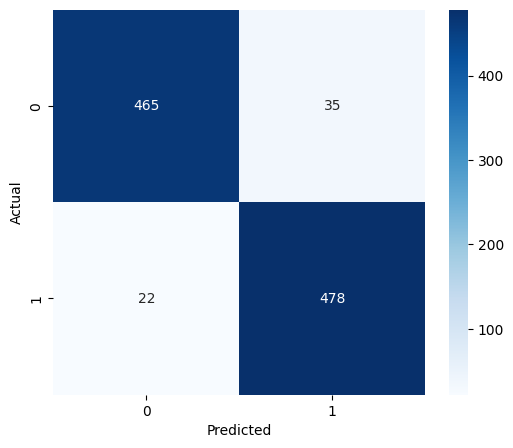

In [7]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(data["label"], (data["pred_label"] == "Sports"))
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Section 4: Error Analysis

#### 4.1 False Negatives

22 False Negative Articles


Text(0.5, 1.0, 'FN Prediction Scores')

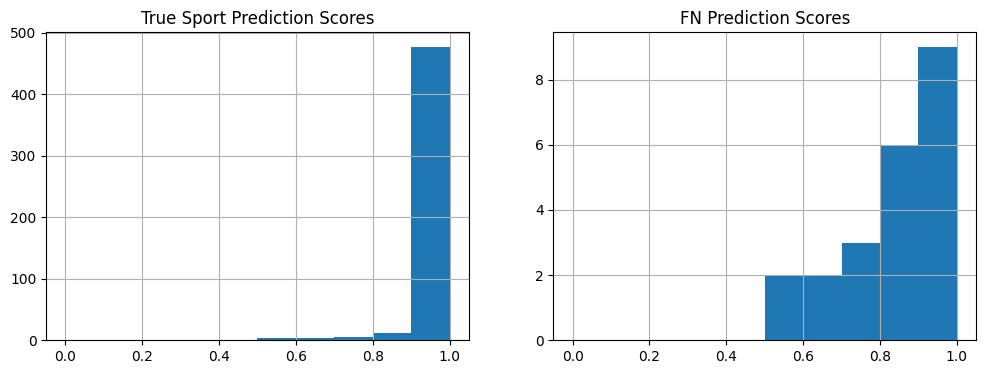

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Check pred_score distribution of false negatives
fns = data[(data["label"] == 1) & (data["pred_label"] != "Sports")]
print(f"{len(fns)} False Negative Articles")

# All pred_score of true sport label, with plot and set title
data[(data["label"] == 1)]["pred_score"].hist(range=(0, 1), ax = axes[0])
axes[0].set_title("True Sport Prediction Scores")

## Plot and set title for FN distribution
fns["pred_score"].hist(range=(0, 1), ax = axes[1])
axes[1].set_title("FN Prediction Scores")

#### 4.2 False Positives

35 False Positive Articles


Text(0.5, 1.0, 'FP Prediction Scores')

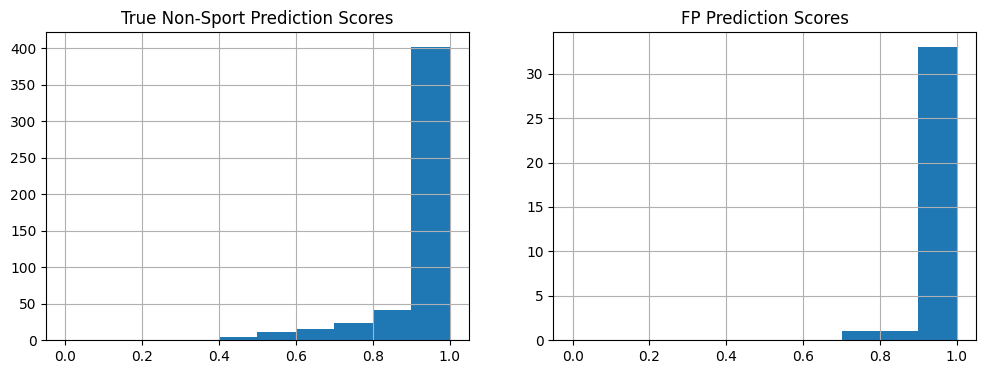

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Check pred_score distribution of false positives
fps = data[(data["label"] == 0) & (data["pred_label"] == "Sports")]
print(f"{len(fps)} False Positive Articles")

# All pred_score of true non-sport label, with plot and set title
data[(data["label"] == 0)]["pred_score"].hist(range=(0, 1), ax = axes[0])
axes[0].set_title("True Non-Sport Prediction Scores")

# Plot and set title for FP distribution
fps["pred_score"].hist(range=(0, 1), ax = axes[1])
axes[1].set_title("FP Prediction Scores")

## Part 2: Sentiment Analysis
### Overview
This notebook demonstrates sentiment analysis using pre-trained transformer models from Hugging Face. We'll analyze movie reviews from the IMDB dataset, applying state-of-the-art NLP models to classify sentiment without any training required.

### Learning Objectives
* Load datasets directly from Kaggle using the kagglehub library
* Apply pre-trained sentiment analysis models to real movie reviews
* Handle large text datasets efficiently through sampling
* Evaluate sentiment classification performance
* Understand the differences between rule-based and transformer-based sentiment analysis

### Section 1: Environment Setup and Data Loading

#### 1.1 Install Required Dependencies

In [10]:
# Install kagglehub with pandas support for dataset loading
# Run this in terminal or uncomment to run in notebook:
# pip install kagglehub[pandas-datasets]

# Import necessary libraries
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
from transformers import pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

#### 1.2 Load the IMDB Dataset

In [11]:
# Set the path to the file you'd like to load
file_path = "IMDB Dataset.csv"

# Load the latest version
imdb_data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "lakshmi25npathi/imdb-dataset-of-50k-movie-reviews",
  file_path
)

print("First 5 records:", imdb_data.head())

/tmp/ipython-input-3068968077.py:5: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  imdb_data = kagglehub.load_dataset(


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
First 5 records:                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### Section 2: Data Sampling and Preparation

In [12]:
sampled_reviews = imdb_data.groupby('sentiment').sample(n=1000, random_state=4)
sampled_reviews['sentiment'].value_counts()

,count
sentiment,
negative,1000
positive,1000


### Section 3: Sentiment Analysis with Pre-trained Models

#### 3.1 Initialize the Sentiment Analysis Pipeline

In [13]:
# Initialize a sentiment analysis pipeline with default model
# Default model: distilbert-base-uncased-finetuned-sst-2-english
sent_classifier = pipeline(
    task="sentiment-analysis",   # Specify the NLP task
    model=None,                   # None uses default model for the task
    max_length=512,              # Maximum token length (BERT/DistilBERT limit)
    truncation=True              # Truncate reviews exceeding max_length
)

# View sent_classifier on example
sent_classifier(sampled_reviews["review"].iloc[0])

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cuda:0


[{'label': 'NEGATIVE', 'score': 0.9979008436203003}]

#### 3.2 Apply Sentiment Analysis to Dataset


In [14]:
# Apply the sent_classifier and clean label to match true label
sampled_reviews["sent_analysis"] = sampled_reviews["review"].apply(lambda text: sent_classifier(text)[0]['label'].lower())
sampled_reviews

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,review,sentiment,sent_analysis
3942,"OK, to start with, this movie was not at all l...",negative,negative
41815,"CQ could have been good, campy fun. But it com...",negative,negative
26637,"If you rent a movie titled ""Exterminators of t...",negative,negative
1898,As much as I dislike saying 'me too' in respon...,negative,negative
30362,"I was prepared for a bad movie, and a bad movi...",negative,positive
...,...,...,...
39008,One of the many backwoods horror's that came o...,positive,positive
23811,"I've seen three of the Animatrix episodes, and...",positive,positive
33920,"17/02/09 ""More"" (1969) Dir: Barbet Schroeder <...",positive,positive
48426,"This was a surprisingly very good movie, and a...",positive,positive


### Section 4: Performance Evaluation

#### 4.1 Classification Report

In [15]:
print(f"Accuracy: {accuracy_score(sampled_reviews["sentiment"], sampled_reviews["sent_analysis"]):.2%}")
print(classification_report(sampled_reviews["sentiment"], sampled_reviews["sent_analysis"]))

Accuracy: 87.55%
              precision    recall  f1-score   support

    negative       0.85      0.92      0.88      1000
    positive       0.91      0.83      0.87      1000

    accuracy                           0.88      2000
   macro avg       0.88      0.88      0.88      2000
weighted avg       0.88      0.88      0.88      2000



#### 4.2 Confusion Matrix

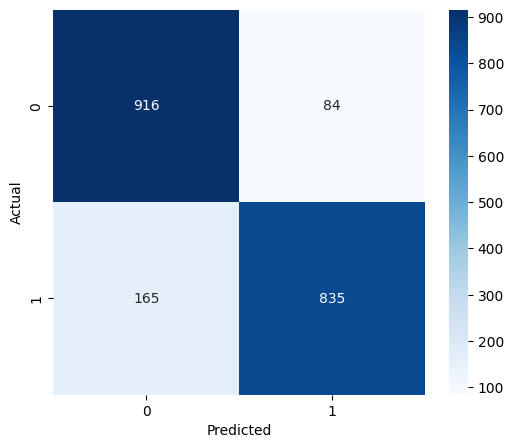

In [16]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(sampled_reviews["sentiment"], sampled_reviews["sent_analysis"])
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt="d",
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()